<a href="https://colab.research.google.com/github/kanri3/deep_learning_day1_day2/blob/main/2_4_1_simple_convolution_hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

# simple convolution network

## image to column

In [ ]:
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# 画像データを２次元配列に変換
'''
input_data: 入力値
filter_h: フィルターの高さ
filter_w: フィルターの横幅
stride: ストライド
pad: パディング

https://stanford.edu/~shervine/l/ja/teaching/cs-230/cheatsheet-convolutional-neural-networks
ストライド：畳み込みまたはプーリング操作において、ストライドSSは各操作の後にウィンドウを移動させるピクセル数を表します。
ゼロパディング：ゼロパディングとは入力の各境界に対してPP個のゼロを追加するプロセスを意味します。
'''
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    # print("input_data.shape:", input_data.shape)
    # //（スラッシュスラッシュ）割り算だが商が整数
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1
    # print("out_h:", out_h, ", out_w", out_w)

    # numpy.pad 要はパディング
    # https://qiita.com/horitaku1124/items/6ae979b21ddc7256b872

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    # print("img:", img)
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    # print("col:", col)

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    # print("col:", col)
    col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    # print("col:", col)
    
    col = col.reshape(N * out_h * out_w, -1)
    return col

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] im2colの処理を確認しよう
・関数内でtransposeの処理をしている行をコメントアウトして下のコードを実行してみよう<br>
・input_dataの各次元のサイズやフィルターサイズ・ストライド・パディングを変えてみよう

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[40. 87. 20. 80.]
   [99. 30. 62. 34.]
   [70. 20. 19. 46.]
   [41. 43. 38. 92.]]]


 [[[90.  7.  6. 81.]
   [70. 94. 10. 83.]
   [29. 12. 19. 39.]
   [26. 54. 48. 26.]]]]
============= col ==============
 [[40. 87. 20. 99. 30. 62. 70. 20. 19.]
 [87. 20. 80. 30. 62. 34. 20. 19. 46.]
 [99. 30. 62. 70. 20. 19. 41. 43. 38.]
 [30. 62. 34. 20. 19. 46. 43. 38. 92.]
 [90.  7.  6. 70. 94. 10. 29. 12. 19.]
 [ 7.  6. 81. 94. 10. 83. 12. 19. 39.]
 [70. 94. 10. 29. 12. 19. 26. 54. 48.]
 [94. 10. 83. 12. 19. 39. 54. 48. 26.]]


## column to image

In [ ]:
# ２次元配列を画像データに変換
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_shape
    # 切り捨て除算    
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2) # (N, filter_h, filter_w, out_h, out_w, C)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## col2imの処理を確認しよう
・im2colの確認で出力したcolをimageに変換して確認しよう

In [ ]:
col2im(col, (2,1,4,4), filter_h, filter_w, stride=1, pad=0)
# col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0)

array([[[[ 40., 174.,  40.,  80.],
         [198., 120., 248.,  68.],
         [140.,  80.,  76.,  92.],
         [ 41.,  86.,  76.,  92.]]],


       [[[ 90.,  14.,  12.,  81.],
         [140., 376.,  40., 166.],
         [ 58.,  48.,  76.,  78.],
         [ 26., 108.,  96.,  26.]]]])

## convolution class

In [ ]:
class Convolution:
    # W: フィルター, b: バイアス
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # フィルター・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        # FN: filter_number, C: channel, FH: filter_height, FW: filter_width
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        # 出力値のheight, width
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        
        # xを行列に変換
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルターをxに合わせた行列に変換
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        # 計算のために変えた形式を戻す
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, d_out):
        FN, C, FH, FW = self.W.shape
        d_out = d_out.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(d_out, axis=0)
        self.dW = np.dot(self.col.T, d_out)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        d_col = np.dot(d_out, self.col_W.T)
        # d_colを画像データに変換
        d_x = col2im(d_col, self.x.shape, FH, FW, self.stride, self.pad)

        return d_x


## pooling class

In [ ]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # xを行列に変換
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # プーリングのサイズに合わせてリサイズ
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 行ごとに最大値を求める
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 整形
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, d_out):
        d_out = d_out.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        d_max = np.zeros((d_out.size, pool_size))
        d_max[np.arange(self.arg_max.size), self.arg_max.flatten()] = d_out.flatten()
        d_max = d_max.reshape(d_out.shape + (pool_size,)) 
        
        d_col = d_max.reshape(d_max.shape[0] * d_max.shape[1] * d_max.shape[2], -1)
        d_x = col2im(d_col, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return d_x


## Relu

In [ ]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

## Affine

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応        
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

## soft max with loss

In [ ]:
# from common import functions

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.d = None # 教師データ

    def forward(self, x, d):
        self.d = d
        self.y = functions.softmax(x)
        self.loss = functions.cross_entropy_error(self.d, self.y)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.d.shape[0]
        if self.d.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.d) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.d] -= 1
            dx = dx / batch_size
        
        return dx

# 活性化関数の導関数
# シグモイド関数（ロジスティック関数）の導関数
def d_sigmoid(x):
    dx = (1.0 - sigmoid(x)) * sigmoid(x)
    return dx

# クロスエントロピー
def cross_entropy_error(d, y):
    if y.ndim == 1:
        d = d.reshape(1, d.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if d.size == y.size:
        d = d.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), d] + 1e-7)) / batch_size

## sinple convolution network class

In [ ]:
class SimpleConvNet:
    # conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']        
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) ** 2)
        # pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        print("self.params['W1'].shape:", self.params['W1'].shape)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict() # 順序付きdictionary
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        print("type(self.layers['Conv1']) :", type(self.layers['Conv1']))
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    # 『レイヤの生成』でself.layersに詰めた順に呼び出す
    def predict(self, x):
        for key in self.layers.keys():
            # Conv1 → Relu1 → … が1000回出ちゃう
            # print("key :", key)
            x = self.layers[key].forward(x)
        return x
        
    # def loss(self, x, d):
    #     for key in self.layers.keys():
    #         # Conv1 → Relu1 → … が1000回出ちゃう
    #         # print("key :", key)
    #         x = self.layers[key].forward(x)

    #     return self.last_layer.forward(x, d)

    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, data2study, data2teach, batch_size=100):
    # def accuracy(self, x, d, batch_size=100):
        if data2teach.ndim != 1 :
            data2teach = np.argmax(data2teach, axis=1)
        acc = 0.0
        for i in range(int(data2study.shape[0] / batch_size)):
            tx = data2study[i * batch_size : ( i + 1 ) * batch_size]
            td = data2teach[i * batch_size : ( i + 1 ) * batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        return acc / data2study.shape[0]

    def gradient(self, data2study, data2teach):
        # forward
        self.loss(data2study, data2teach)
        # backward
        d_out = 1
        d_out = self.last_layer.backward(d_out)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            d_out = layer.backward(d_out)
        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W3'], grad['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grad

## Adam

In [ ]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grad):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.learning_rate * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grad[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grad[key] ** 2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

## 繰り返し

データ読み込み完了
self.params['W1'].shape: (30, 1, 5, 5)
type(self.layers['Conv1']) : <class '__main__.Convolution'>
Generation: 1. 正答率(トレーニング) = 0.1225
                : 1. 正答率(テスト) = 0.105
Generation: 100. 正答率(トレーニング) = 0.806
                : 100. 正答率(テスト) = 0.774
Generation: 200. 正答率(トレーニング) = 0.8515
                : 200. 正答率(テスト) = 0.79
Generation: 300. 正答率(トレーニング) = 0.8955
                : 300. 正答率(テスト) = 0.836
Generation: 400. 正答率(トレーニング) = 0.9175
                : 400. 正答率(テスト) = 0.875
Generation: 500. 正答率(トレーニング) = 0.9455
                : 500. 正答率(テスト) = 0.882


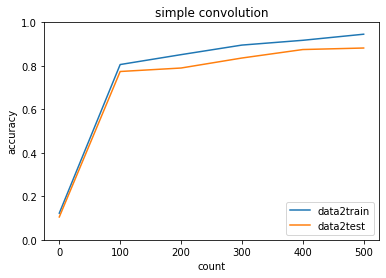

In [ ]:
# from common import optimizer

# データの読み込み
(x_train, tch_train), (x_test, tch_test) = load_mnist(flatten=False)
print("データ読み込み完了")

# 処理に時間のかかる場合はデータを削減 
x_train, tch_train = x_train[:2000], tch_train[:2000]
# x_train, tch_train = x_train[:5000], tch_train[:5000]
x_test, tch_test = x_test[:1000], tch_test[:1000]

network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer_adam = Adam()
# optimizer = optimizer.Adam()

iters_num = 500
# iters_num = 1000
train_size = x_train.shape[0]
batch_size = 10
# batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=100
# plot_interval=10

for i in range(iters_num):
    # ミニバッチデータ作成
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    tch_batch = tch_train[batch_mask]
    
    grad = network.gradient(x_batch, tch_batch)
    optimizer_adam.update(network.params, grad)

    loss = network.loss(x_batch, tch_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0 or i==0:
    # if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, tch_train, batch_size)
        accr_test = network.accuracy(x_test, tch_test, batch_size)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num + 1, plot_interval)
# lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="data2train")
plt.plot(lists, accuracies_test,  label="data2test")
plt.legend(loc="lower right")
plt.title("simple convolution")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()